### Visualize

In [84]:
### 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from scipy import stats

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler

### 환경설정
np.random.seed(4)

### 함수 정의
def preprocess_transaction_flag(df):
    df['transaction_flag'] = df['transaction_count'].apply(lambda x: 1 if x > 0 else 0)
    return df

def trim_date(df, start, end):
    ### df date 형식 맞춰주기
    df['date'] = df['date'].astype(str)
    if len(df['date'][0]) == 8:
        df['date'] = df['date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])


    return df[(df['date']>=start) & (df['date']<=end)]

### 데이터 세팅

In [ ]:
### 학습용 데이터 읽기
test_df = pd.read_csv("./data/test/test_df.csv")
test_df.set_index('date', inplace=True)

### 이벤트용 데이터 읽기
# event_df = pd.read_csv("./data/event/bitcoin_event_details_sentiment.csv")
event_df = pd.read_csv("./data/event/bitcoin_event_detail_no_explain.csv")
event_df.index = event_df['Date'].astype(str).apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])
event_df = event_df[event_df['predict']==1]

# target_event_receive_df = pd.read_csv("./data/target/screened_event_2_day_transactions_over_25_threshold_1000_receive.csv")
target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_136_threshold_1000_receive.csv")
target_event_receive_df = preprocess_transaction_flag(target_event_receive_df)
target_event_receive_df.columns = ['date', 'transaction_count', 'transaction_amount', 'transaction_flag']

target_event_receive_df = trim_date(target_event_receive_df, (test_df.index)[0], (test_df.index)[-1])



### Bitcoin Event Flag 추가 / 긍정, 부정, 애매 이벤트 필터링
# pos, neg, neu, all
event_sentiment = 'neg'
if event_sentiment == 'all':
    pass
elif event_sentiment == 'pos':
    event_df = event_df[event_df['classification']==1]
elif event_sentiment == 'neg':
    event_df = event_df[event_df['classification']==0]
elif event_sentiment == 'neu':
    event_df = event_df[event_df['classification']==2]
event_df['classification'] = 1
event_df = event_df['classification']
event_df = event_df[~event_df.index.duplicated(keep='first')]

test_df['event_flag'] = event_df
test_df['event_flag'] = test_df['event_flag'].fillna(0)

### 분석 데이터 선택
target_df = target_event_receive_df.copy().set_index('date')

### test_df에 target_df 데이터 적용
test_df['transaction_count'] = target_df['transaction_count']
test_df['transaction_amount'] = target_df['transaction_amount']
test_df['transaction_flag'] = target_df['transaction_flag']
test_df['transaction_amount_usd'] = test_df['transaction_amount'] * test_df['close']

### test_df의 target 선택
test_df['target'] = test_df['transaction_amount_usd']
test_df['target'] = np.where(test_df['target'] == 0, 1e-10, test_df['target'])

### target 관련 파생변수 생성
test_df['target_delta'] = test_df['target'].diff(1)
test_df['target_returns'] = test_df['target'].pct_change(1)

### VPIN 관련 변수 추가
vpin = pd.read_csv('./data/vpin/vpin.csv')
vpin['ma_10'] = vpin['vpin'].rolling(10).mean()
vpin['ma_10'] = vpin['ma_10'].fillna(vpin['ma_10'].mean())
vpin = vpin.set_index('date')

test_df['vpin'] = vpin['vpin']
test_df['vpin_ma_10'] = vpin['ma_10']

##### 전처리 관련
test_df = test_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.fillna(test_df.mean())


C:\Users\slaye\AppData\Local\Temp\ipykernel_34732\1753658916.py:53: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['target_returns'] = test_df['target'].pct_change(1)


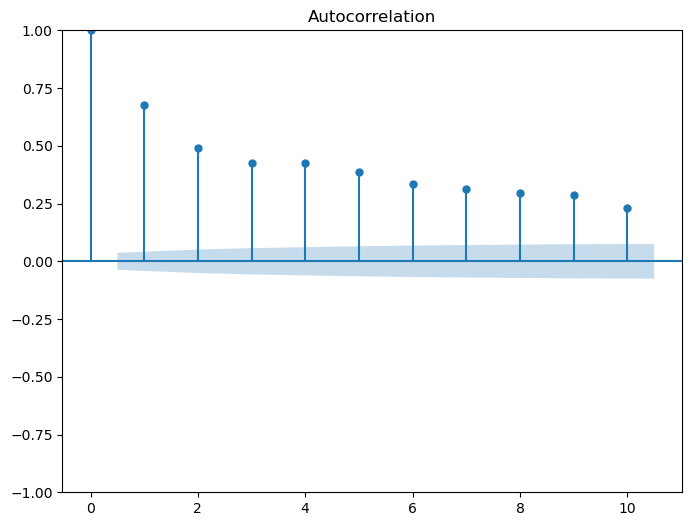

[[1.         0.86980591]
 [0.86980591 1.        ]]


In [86]:
##### Auto Correlation

### target 값의 autocorrelation
sm.tsa.stattools.acf(test_df['target'], nlags=10, fft=False)

fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(test_df['target'], lags=10, ax=ax)
plt.show()


### Transaction Amount, Transaction Count 사이 상관관계
print(np.corrcoef([test_df.transaction_amount, test_df.transaction_count]))

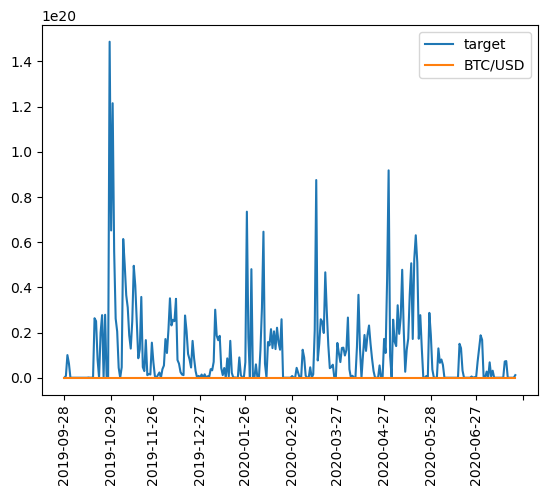

In [87]:
### target값과 가격 그래프
plot_df = test_df.iloc[1000:1300, :]
plt.plot(plot_df['target']/plot_df['target'].iloc[0], label='target')
plt.plot(plot_df['close']/plot_df['close'].iloc[0], label='BTC/USD')
plt.xticks(rotation=90)
plt.legend()

ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정

plt.show()

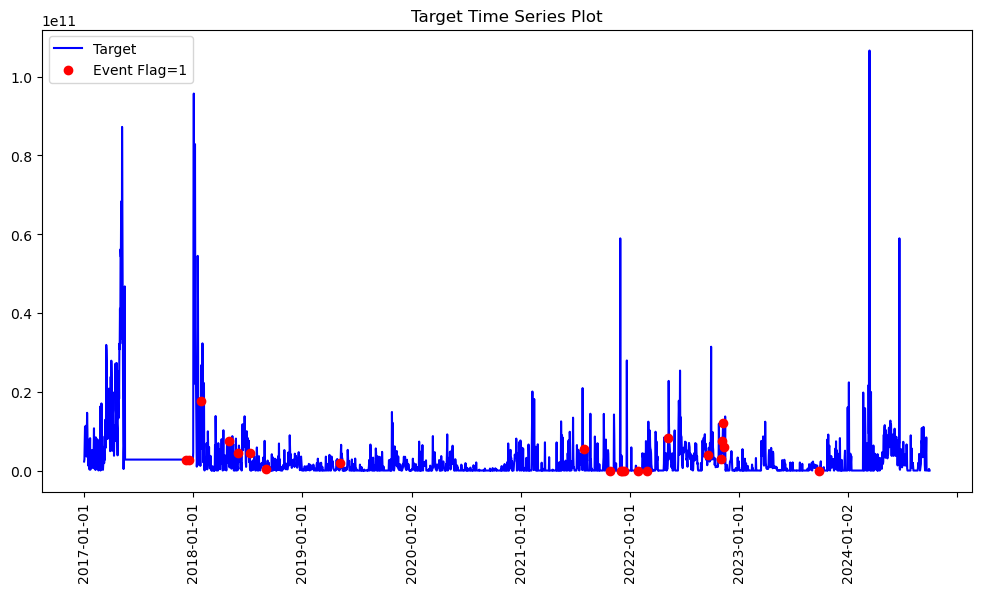

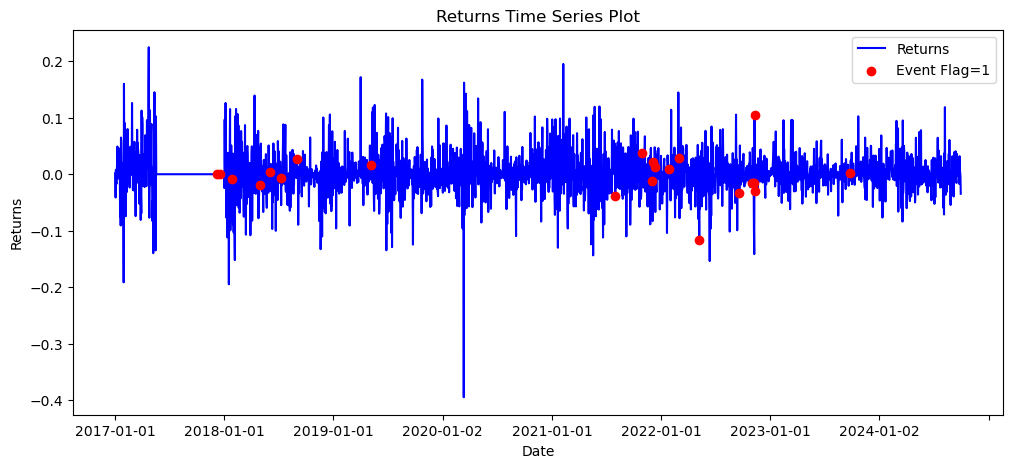

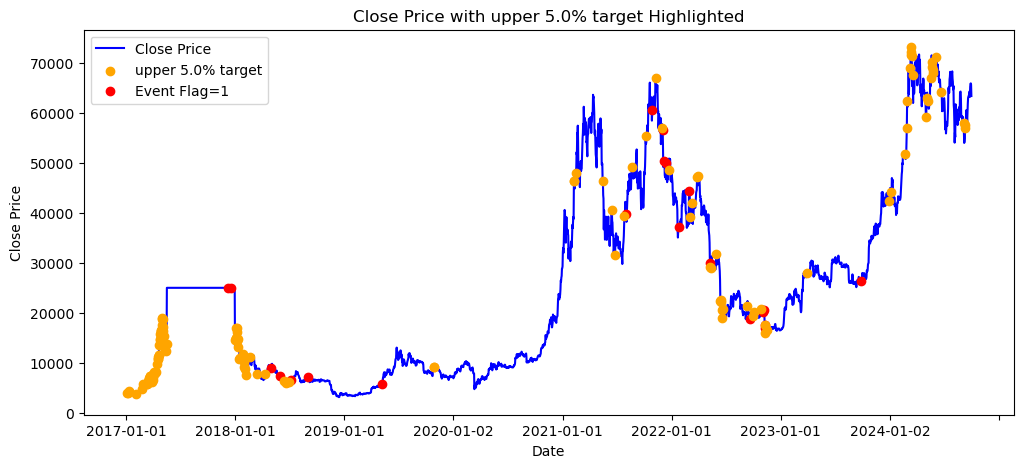

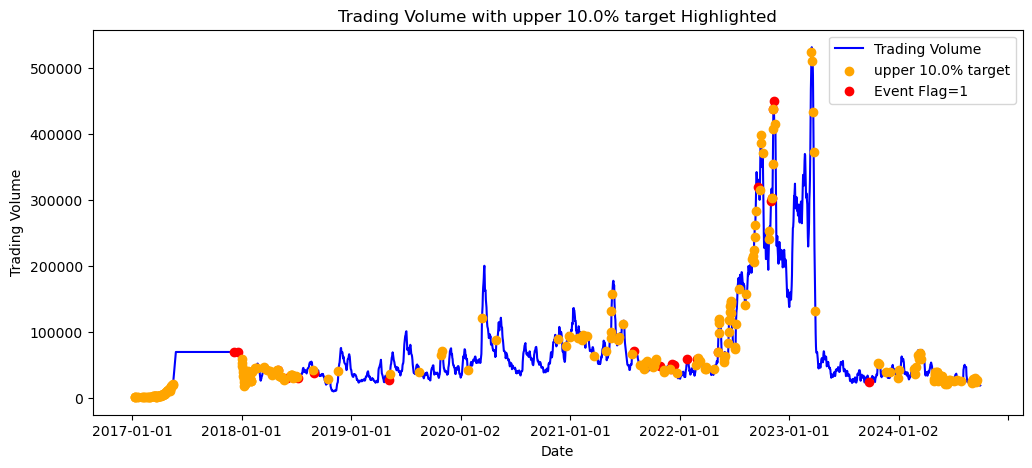

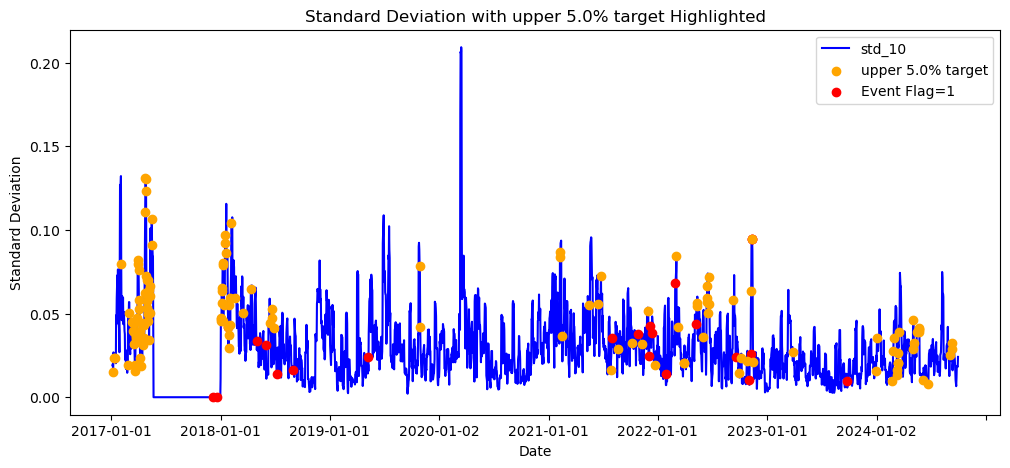

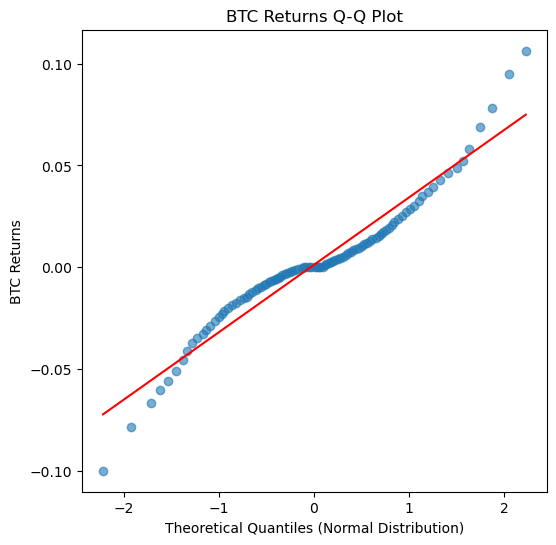

In [88]:
# 데이터 복사 및 이벤트 플래그 추가
transaction_amount_usd_plot = test_df.transaction_amount_usd.copy().to_frame()
transaction_amount_usd_plot['event_flag'] = test_df['event_flag']

# # 날짜별 데이터 필터링
start_date = '2017-01-01'
end_date = '2024-12-31'

transaction_amount_usd_plot = transaction_amount_usd_plot[(transaction_amount_usd_plot.index >= start_date)&(transaction_amount_usd_plot.index <= end_date)]

# 이벤트가 발생한 지점 찾기 (event_flag == 1 인 경우)
event_indices = transaction_amount_usd_plot[transaction_amount_usd_plot['event_flag'] == 1].index
event_values = transaction_amount_usd_plot.loc[event_indices, transaction_amount_usd_plot.columns[0]]  # target 값

# 타임 시리즈 그래프
plt.figure(figsize=(12, 6))
plt.plot(transaction_amount_usd_plot.iloc[:, 0], label='Target', color='blue')  # 첫 번째 컬럼이 target 값
plt.scatter(event_indices, event_values, color='red', label="Event Flag=1", zorder=3)  # 이벤트 발생 시점 표시

plt.xticks(rotation=90)
plt.title("Target Time Series Plot")
plt.legend()

# X축 날짜 포맷 자동 조정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()

############
### 수익률 Time Series Plot
plt.figure(figsize=(12, 5))
returns_plot = test_df[(test_df.index >= start_date)&(test_df.index <= end_date)].copy()
plt.plot(returns_plot.index, returns_plot['returns'], label="Returns", color='blue')

# 이벤트가 발생한 지점 찾기 (event_flag == 1 인 경우)
event_indices = returns_plot[returns_plot['event_flag'] == 1].index
event_values = returns_plot.loc[event_indices, 'returns']  # target 값
plt.scatter(event_indices, event_values, color='red', label="Event Flag=1", zorder=3)  # 이벤트 발생 시점 표시
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Returns Time Series Plot")
plt.legend()

ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정
plt.show()
#############

########################
## 가격
# Figure 설정
plt.figure(figsize=(12, 5))

# 기간 필터링
price_plot = test_df[(test_df.index >= start_date) & (test_df.index <= end_date)].copy()

# Price 시계열 그래프
plt.plot(price_plot.index, price_plot['close'], label="Close Price", color='blue')

# 인덱스 필터링 조건 설정
top = 0.05
condition = 'upper' # upper or lower
target = 'target' # target or target_delta 

upper_threshold = price_plot[target].quantile(1-top)
lower_threshold = price_plot[target].quantile(top)
if condition == 'upper':
    event_indices = price_plot[price_plot[target] >= upper_threshold].index
if condition == 'lower':
    event_indices = price_plot[price_plot[target] <= lower_threshold].index
event_values = price_plot.loc[event_indices, 'close']  # event 발생 시점의 'close' 값

# 상위 10% transaction_amount가 발생한 날의 close 값에 점 찍기 (빨간색)
plt.scatter(
    event_indices, event_values,
    color='orange', label=f'{condition} {top*100}% {target}', zorder=5
) 

# 이벤트가 발생한 지점 찾기 (event_flag == 1 인 경우)
event_indices = price_plot[price_plot['event_flag'] == 1].index
event_values = price_plot.loc[event_indices, 'close']  # event 발생 시점의 'close' 값

# 이벤트 발생 지점 표시 (주황색)
plt.scatter(
    event_indices, event_values,
    color='red', label="Event Flag=1", zorder=4
)

# 그래프 설정
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title(f'Close Price with {condition} {top*100}% {target} Highlighted')
plt.legend()

# X축 날짜 포맷 자동 조정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()
#############



########################
## Volume 시계열 확인
# Figure 설정
plt.figure(figsize=(12, 5))

# 기간 필터링
volume_plot = test_df[(test_df.index >= start_date) & (test_df.index <= end_date)].copy()
volume_plot['ma_10'] = volume_plot['volume'].rolling(10).mean()

# Volume 시계열 그래프
plt.plot(volume_plot.index, volume_plot['ma_10'], label="Trading Volume", color='blue')

# 인덱스 필터링 조건 설정
top = 0.1
condition = 'upper' # upper or lower
target = 'target' # target or target_delta 

upper_threshold = volume_plot[target].quantile(1-top)
lower_threshold = volume_plot[target].quantile(top)
if condition == 'upper':
    event_indices = volume_plot[volume_plot[target] >= upper_threshold].index
if condition == 'lower':
    event_indices = volume_plot[volume_plot[target] <= lower_threshold].index
event_values = volume_plot.loc[event_indices, 'ma_10']  # event 발생 시점의 'close' 값

# 상위 10% transaction_amount가 발생한 날의 close 값에 점 찍기 (빨간색)
plt.scatter(
    event_indices, event_values,
    color='orange', label=f'{condition} {top*100}% {target}', zorder=5
) 

# 이벤트가 발생한 지점 찾기 (event_flag == 1 인 경우)
event_indices = volume_plot[volume_plot['event_flag'] == 1].index
event_values = volume_plot.loc[event_indices, 'ma_10']  # event 발생 시점의 'close' 값

# 이벤트 발생 지점 표시 (주황색)
plt.scatter(
    event_indices, event_values,
    color='red', label="Event Flag=1", zorder=4
)

# 그래프 설정
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.title(f'Trading Volume with {condition} {top*100}% {target} Highlighted')
plt.legend()

# X축 날짜 포맷 자동 조정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()
#############


########################
## Std 시계열 확인
# Figure 설정
plt.figure(figsize=(12, 5))

# 기간 필터링
std_plot = test_df[(test_df.index >= start_date) & (test_df.index <= end_date)].copy()
std_plot['std_10'] = std_plot['returns'].rolling(5).std()

# 'std_10' 시계열 그래프
plt.plot(std_plot.index, std_plot['std_10'], label='std_10', color='blue')

# 인덱스 필터링 조건 설정
top = 0.05
condition = 'upper' # upper or lower
target = 'target' # target or target_delta 

upper_threshold = std_plot[target].quantile(1-top)
lower_threshold = std_plot[target].quantile(top)
if condition == 'upper':
    event_indices = std_plot[std_plot[target] >= upper_threshold].index
if condition == 'lower':
    event_indices = std_plot[std_plot[target] <= lower_threshold].index
event_values = std_plot.loc[event_indices, 'std_10']  # event 발생 시점의 'close' 값

# 상위 10% transaction_amount가 발생한 날의 close 값에 점 찍기 (빨간색)
plt.scatter(
    event_indices, event_values,
    color='orange', label=f'{condition} {top*100}% {target}', zorder=5
) 

# 이벤트가 발생한 지점 찾기 (event_flag == 1 인 경우)
event_indices = std_plot[std_plot['event_flag'] == 1].index
event_values = std_plot.loc[event_indices, 'std_10']  # event 발생 시점의 'close' 값

# 이벤트 발생 지점 표시 (주황색)
plt.scatter(
    event_indices, event_values,
    color='red', label="Event Flag=1", zorder=4
)

# 그래프 설정
plt.xlabel("Date")
plt.ylabel("Standard Deviation")
plt.title(f'Standard Deviation with {condition} {top*100}% {target} Highlighted')
plt.legend()

# X축 날짜 포맷 자동 조정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()
#############




###############
### 비트코인 Returns의 Q-Q Plot
normal_dist = lambda l : np.random.standard_normal(l)

btc_ret = test_df['returns']

q_count = 100
quantiles = lambda q: np.arange(1/q, 1, 1/q)

btc_q = btc_ret.quantile(quantiles(q_count))

st_nm_dist = pd.Series(normal_dist(len(btc_ret)))
nd_q = st_nm_dist.quantile(quantiles(q_count))

plt.figure(figsize=(6,6))
plt.scatter(nd_q, btc_q, alpha=0.6)

x, y = nd_q, btc_q
lr_params = stats.linregress(x, y)
slope, intercept = lr_params[0], lr_params[1]
lr_model = slope * x + intercept
plt.plot(x, lr_model, color='red')

plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('BTC Returns')
plt.title('BTC Returns Q-Q Plot')

plt.show()

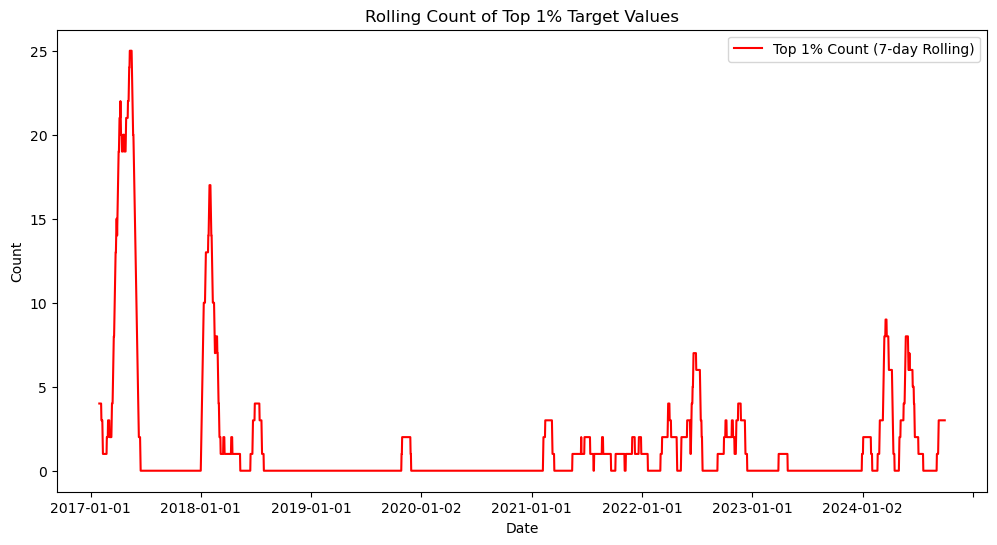

In [89]:
# 상위 1% 필터링
top_1_threshold = price_plot['target'].quantile(0.95)
price_plot['top_1_flag'] = (price_plot['target'] >= top_1_threshold).astype(int)

# 상위 1% 값 플래그 추가
price_plot['top_1_flag'] = (price_plot['target'] >= top_1_threshold).astype(int)

# 롤링 카운트
price_plot['rolling_count'] = price_plot['top_1_flag'].rolling(window=30).sum()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(price_plot.index, price_plot['rolling_count'], label='Top 1% Count (7-day Rolling)', color='red')
plt.title("Rolling Count of Top 1% Target Values")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()

# X축 날짜 포맷 자동 조정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()


### 

### 이벤트 발생 전후로 Transaction

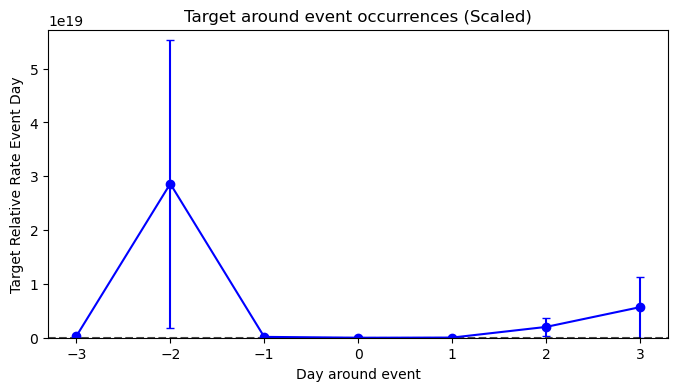

In [90]:
# 계산 편리를 위한 인덱스 초기화 
date_index = test_df.index
test_df.reset_index(drop=True, inplace=True)

# 이벤트 발생 인덱스 찾기
event_indices = test_df.index[test_df['event_flag'] == 1]


# 이벤트 중심 데이터 저장할 리스트
event_window = range(-3, 4)  # -10일 ~ +10일 윈도우
event_data = {day: [] for day in event_window}


# 각 이벤트 발생일을 기준으로 -10일 ~ +10일 데이터 수집
for event_idx in event_indices:
    for day in event_window:
        target_idx = event_idx + day
        if 0 <= target_idx < len(test_df):  # 인덱스 범위 체크
            event_data[day].append(test_df.loc[target_idx, 'target'])
    

test_df.index = date_index

event_cal_df = pd.DataFrame(event_data)
event_cal_df = (event_cal_df - event_cal_df.iloc[:, 3].values.reshape(-1, 1)) / event_cal_df.iloc[:, 3].values.reshape(-1, 1)


# event_cal_df를 활용해 각 날짜별 평균 및 표준오차 계산
event_avg = event_cal_df.mean()
event_std = event_cal_df.std() / np.sqrt(event_cal_df.shape[0])  # 표준오차(SE) 계산

# 데이터프레임 생성
event_transaction_df = pd.DataFrame({
    'Day': event_window,
    'Mean': event_avg.values,
    'SE': event_std.values
})

event_transaction_df['Relative Change (%)'] = (event_transaction_df['Mean'])
event_transaction_df['SE Change (%)'] = (event_transaction_df['SE'])

# 그래프 그리기
plt.figure(figsize=(8, 4))
# plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
#              yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
             yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 0 축
plt.xlabel("Day around event")
plt.ylabel("Target Relative Rate Event Day")
plt.title("Target around event occurrences (Scaled)")

plt.ylim(event_transaction_df['Relative Change (%)'].min() * 1.5, event_transaction_df['Relative Change (%)'].max() * 2.0)

# # 고해상도 저장
# plt.savefig('./figure/target_around_neg_event_occurrences.pdf', dpi=300, bbox_inches='tight')

plt.show()


### Random Sampling, Population

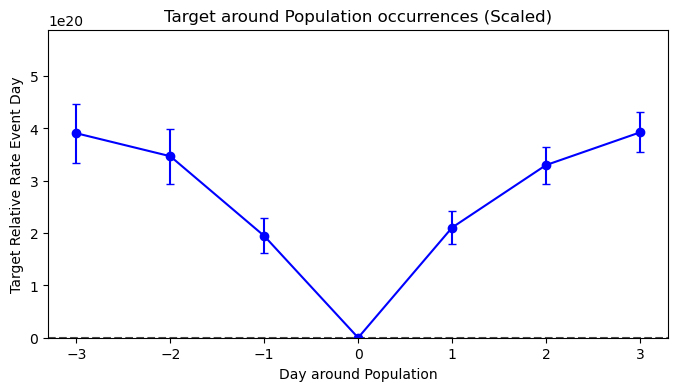

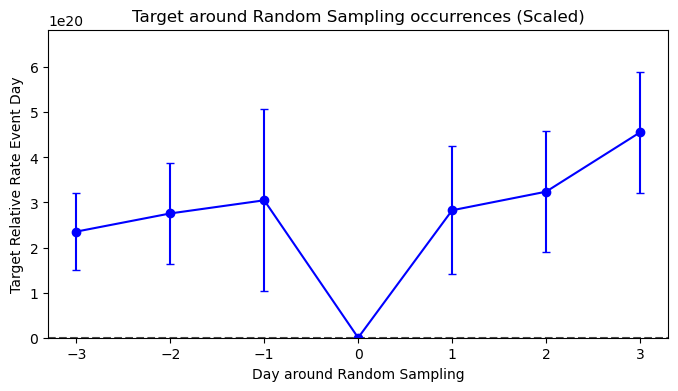

In [91]:
### Population
# 계산 편리를 위한 인덱스 초기화 
date_index = test_df.index
test_df.reset_index(drop=True, inplace=True)


# 전체 인덱스 선택
event_indices = [i for i in range(3, len(test_df) - 4)]

# 이벤트 중심 데이터 저장할 리스트
event_window = range(-3, 4)  # -10일 ~ +10일 윈도우
event_data = {day: [] for day in event_window}

# 각 이벤트 발생일을 기준으로 -10일 ~ +10일 데이터 수집
for event_idx in event_indices:
    for day in event_window:
        target_idx = event_idx + day
        if 0 <= target_idx < len(test_df):  # 인덱스 범위 체크
            event_data[day].append(test_df.loc[target_idx, 'target'])

test_df.index = date_index


### Event 당일 대비 차이율 계산
event_cal_df = pd.DataFrame(event_data)
event_cal_df = (event_cal_df - event_cal_df.iloc[:, 3].values.reshape(-1, 1)) / event_cal_df.iloc[:, 3].values.reshape(-1, 1)


# event_cal_df를 활용해 각 날짜별 평균 및 표준오차 계산
event_avg = event_cal_df.mean()
event_std = event_cal_df.std() / np.sqrt(event_cal_df.shape[0])  # 표준오차(SE) 계산

# 데이터프레임 생성
event_transaction_df = pd.DataFrame({
    'Day': event_window,
    'Mean': event_avg.values,
    'SE': event_std.values
})

se_baseline = event_transaction_df[event_transaction_df['Day'] == 0]['SE'].values[0]  # 0일 기준
event_transaction_df['Relative Change (%)'] = (event_transaction_df['Mean']) * 100
event_transaction_df['SE Change (%)'] = (event_transaction_df['SE']) * 100

# 그래프 그리기
plt.figure(figsize=(8, 4))
plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
             yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 0 축
plt.xlabel("Day around Population")
plt.ylabel("Target Relative Rate Event Day")
plt.title("Target around Population occurrences (Scaled)")

plt.ylim(event_transaction_df['Relative Change (%)'].min() * 1.5, event_transaction_df['Relative Change (%)'].max() * 1.5)

plt.show()


### 랜덤 샘플링했을때 Event Day보다 다른 날짜의 Mean이 큰 이유는 변화율을 기준으로 했기 때문이다
### 100 -> 1000 (1000%)   , 1000 -> 100 -> (-90%) 평균 455%


##### Random Sampling
#### 
# 계산 편리를 위한 인덱스 초기화 
date_index = test_df.index
test_df.reset_index(drop=True, inplace=True)


# 100개의 랜덤 인덱스 선택
num_samples = 150
np.random.seed(13)
event_indices = np.random.randint(3, len(test_df) - 4, size=num_samples)
event_indices = list(set(event_indices))

# 이벤트 중심 데이터 저장할 리스트
event_window = range(-3, 4)  # -10일 ~ +10일 윈도우
event_data = {day: [] for day in event_window}

# 각 이벤트 발생일을 기준으로 -10일 ~ +10일 데이터 수집
for event_idx in event_indices:
    for day in event_window:
        target_idx = event_idx + day
        if 0 <= target_idx < len(test_df):  # 인덱스 범위 체크
            event_data[day].append(test_df.loc[target_idx, 'target'])

test_df.index = date_index

event_cal_df = pd.DataFrame(event_data)
event_cal_df = (event_cal_df - event_cal_df.iloc[:, 3].values.reshape(-1, 1)) / event_cal_df.iloc[:, 3].values.reshape(-1, 1)


# event_cal_df를 활용해 각 날짜별 평균 및 표준오차 계산
event_avg = event_cal_df.mean()
event_std = event_cal_df.std() / np.sqrt(event_cal_df.shape[0])  # 표준오차(SE) 계산

# 데이터프레임 생성
event_transaction_df = pd.DataFrame({
    'Day': event_window,
    'Mean': event_avg.values,
    'SE': event_std.values
})

se_baseline = event_transaction_df[event_transaction_df['Day'] == 0]['SE'].values[0]  # 0일 기준
event_transaction_df['Relative Change (%)'] = (event_transaction_df['Mean']) * 100
event_transaction_df['SE Change (%)'] = (event_transaction_df['SE']) * 100

# 그래프 그리기
plt.figure(figsize=(8, 4))
plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
             yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 0 축
plt.xlabel("Day around Random Sampling")
plt.ylabel("Target Relative Rate Event Day")
plt.title("Target around Random Sampling occurrences (Scaled)")

plt.ylim(event_transaction_df['Relative Change (%)'].min() * 1.5, event_transaction_df['Relative Change (%)'].max() * 1.5)

plt.show()


### 랜덤 샘플링했을때 Event Day보다 다른 날짜의 Mean이 큰 이유는 저렇게 잡았을 때 Event 날 Transaction이 클 경우보다
### 그 주변 날짜에 Transaction이 큰 날이 들어갈 확률이 높기 때문이다.


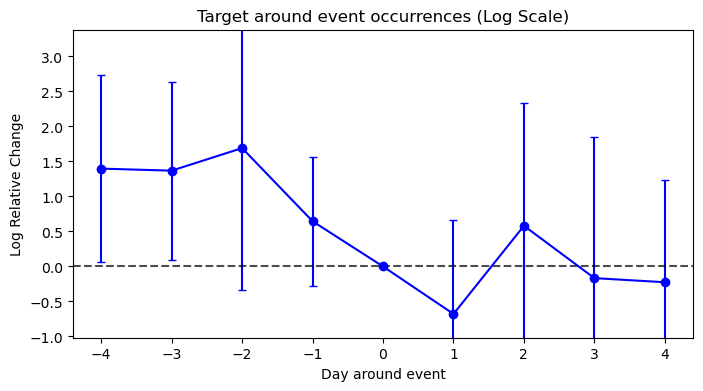

In [92]:
# 계산 편리를 위한 인덱스 초기화 
date_index = test_df.index
test_df.reset_index(drop=True, inplace=True)

# 이벤트 발생 인덱스 찾기
event_indices = test_df.index[test_df['event_flag'] == 1]

# 이벤트 중심 데이터 저장할 리스트
event_window = range(-4, 5)  # -3일 ~ +3일 윈도우
event_data = {day: [] for day in event_window}

# 각 이벤트 발생일을 기준으로 -3일 ~ +3일 데이터 수집
for event_idx in event_indices:
    for day in event_window:
        target_idx = event_idx + day
        if 0 <= target_idx < len(test_df):  # 인덱스 범위 체크
            event_data[day].append(test_df.loc[target_idx, 'target'])

# 인덱스 복원
test_df.index = date_index

# 이벤트 데이터를 데이터프레임으로 변환 후 로그 차이 계산
event_cal_df = pd.DataFrame(event_data)
event_cal_df = (np.log1p(np.maximum(event_cal_df, 0) + 1e-6) - 
                np.log1p(event_cal_df.iloc[:, 4].values.reshape(-1, 1) + 1e-6))

# 각 날짜별 평균 및 표준오차 계산
event_avg = event_cal_df.mean()
event_std = event_cal_df.std() / np.sqrt(event_cal_df.shape[0])  # 표준오차(SE)

# 결과 데이터프레임 생성
event_transaction_df = pd.DataFrame({
    'Day': event_window,
    'Mean': event_avg.values,
    'SE': event_std.values
})

# 로그 스케일 값을 그대로 사용 (단위 명확화)
event_transaction_df['Relative Change (Log Scale)'] = event_transaction_df['Mean']
event_transaction_df['SE (Log Scale)'] = event_transaction_df['SE']

# 그래프 그리기
plt.figure(figsize=(8, 4))
plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (Log Scale)'],
             yerr=event_transaction_df['SE (Log Scale)'], fmt='-o', color='blue', capsize=3)
plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 기준선 (로그 스케일에서 0)
plt.xlabel("Day around event")
plt.ylabel("Log Relative Change")
plt.title("Target around event occurrences (Log Scale)")
plt.ylim(event_transaction_df['Relative Change (Log Scale)'].min() * 1.5, 
        event_transaction_df['Relative Change (Log Scale)'].max() * 2)


# 고해상도 저장
plt.savefig('./figure/target_around_neg_event_occurrences_log_scale.pdf', dpi=300, bbox_inches='tight')

plt.show()

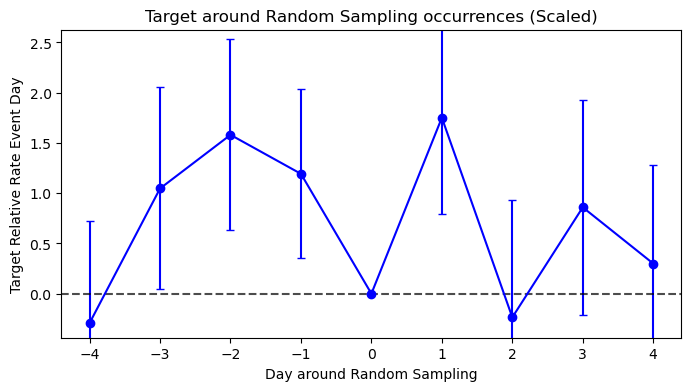

In [93]:

##### Random Sampling
#### 
# 계산 편리를 위한 인덱스 초기화 
date_index = test_df.index
test_df.reset_index(drop=True, inplace=True)


# 100개의 랜덤 인덱스 선택
num_samples = 100
np.random.seed(4)
event_indices = np.random.randint(3, len(test_df) - 4, size=num_samples)
event_indices = list(set(event_indices))

# 이벤트 중심 데이터 저장할 리스트
event_window = range(-4, 5)  # -10일 ~ +10일 윈도우
event_data = {day: [] for day in event_window}

# 각 이벤트 발생일을 기준으로 -10일 ~ +10일 데이터 수집
for event_idx in event_indices:
    for day in event_window:
        target_idx = event_idx + day
        if 0 <= target_idx < len(test_df):  # 인덱스 범위 체크
            event_data[day].append(test_df.loc[target_idx, 'target'])

test_df.index = date_index

# 이벤트 데이터를 데이터프레임으로 변환 후 로그 차이 계산
event_cal_df = pd.DataFrame(event_data)
event_cal_df = (np.log1p(np.maximum(event_cal_df, 0) + 1e-6) - 
                np.log1p(event_cal_df.iloc[:, 4].values.reshape(-1, 1) + 1e-6))


# event_cal_df를 활용해 각 날짜별 평균 및 표준오차 계산
event_avg = event_cal_df.mean()
event_std = event_cal_df.std() / np.sqrt(event_cal_df.shape[0])  # 표준오차(SE) 계산

# 데이터프레임 생성
event_transaction_df = pd.DataFrame({
    'Day': event_window,
    'Mean': event_avg.values,
    'SE': event_std.values
})

event_transaction_df['Relative Change (%)'] = (event_transaction_df['Mean'])
event_transaction_df['SE Change (%)'] = (event_transaction_df['SE'])

# 그래프 그리기
plt.figure(figsize=(8, 4))
plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
             yerr=event_transaction_df['SE Change (%)'], fmt='-o', color='blue', capsize=3)

plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 0 축
plt.xlabel("Day around Random Sampling")
plt.ylabel("Target Relative Rate Event Day")
plt.title("Target around Random Sampling occurrences (Scaled)")

plt.ylim(event_transaction_df['Relative Change (%)'].min() * 1.5, event_transaction_df['Relative Change (%)'].max() * 1.5)

plt.show()
